In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 31.5 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

# Import common libraries
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from random import random
# For disabling warning pop-ups
import warnings
warnings.simplefilter('ignore')
# Import for the data
import tensorflow.image as tfi
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img 
from tensorflow.keras.utils import img_to_array
# Import for the layers
from keras.layers import ReLU
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import concatenate
from keras.layers import ZeroPadding2D
from keras.layers import Conv2DTranspose
from tensorflow_addons.layers import InstanceNormalization
# Import for the model functions
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential
from keras.initializers import RandomNormal
# Import for the Optimizers
from tensorflow.keras.optimizers import Adam
# Import for the losses
from keras.losses import BinaryCrossentropy
# Import for the Model Viz
from tensorflow.keras.utils import plot_model

In [ ]:
def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

In [ ]:
root_horse_path = '/content/drive/MyDrive/GAN Excercise/archive (2)/trainA'
root_zebra_path = '/content/drive/MyDrive/GAN Excercise/archive (2)/trainB'
horse_paths = sorted(glob(root_horse_path + '/*.jpg'))[:1000]
zebra_paths = sorted(glob(root_zebra_path + '/*.jpg'))[:1000]

In [ ]:
SIZE = 256
horse_images, zebra_images = np.zeros(shape=(len(horse_paths),SIZE,SIZE,3)), np.zeros(shape=(len(horse_paths),SIZE,SIZE,3))
for i,(horse_path, zebra_path) in tqdm(enumerate(zip(horse_paths, zebra_paths)), desc='Loading'):
    
    horse_image = img_to_array(load_img(horse_path))
    horse_image = tfi.resize(tf.cast(horse_image, tf.float32)/255., (SIZE, SIZE))
    
    zebra_image = img_to_array(load_img(zebra_path))
    zebra_image = tfi.resize(tf.cast(zebra_image,tf.float32)/255., (SIZE, SIZE))
    
    # as the data is unpaired so we don't have to worry about, positioning the images.
    
    horse_images[i] = horse_image
    zebra_images[i] = zebra_image

Loading: 1000it [14:13,  1.17it/s]


In [ ]:
dataset = [horse_images, zebra_images]

In [ ]:
# Visualizing
for i in range(10):
    id = np.random.randint(len(horse_images))
    horse, zebra = horse_images[id], zebra_images[id]
    
    plt.figure(figsize=(10,8))
    
    plt.subplot(1,2,1)
    show_image(horse)
    
    plt.subplot(1,2,2)
    show_image(zebra)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def ResidualBlock(filters, layer, index):
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False, name="Block_{}_Conv1".format(index))(layer)
    x = InstanceNormalization(axis=-1, name="Block_{}_Normalization1".format(index))(x)
    x = ReLU(name="Block_{}_ReLU".format(index))(x)
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False, name="Block_{}_Conv2".format(index))(x)
    x = InstanceNormalization(axis=-1, name="Block_{}_Normalization2".format(index))(x)
    x = concatenate([x, layer], name="Block_{}_Merge".format(index))
    return x

# create the main model architecture
def downsample(filters, layer, size=3, strides=2, activation=None, index=None, norm=True):
    x = Conv2D(filters, kernel_size=size, strides=strides, padding='same', kernel_initializer='he_normal', use_bias=False, name="Encoder_{}_Conv".format(index))(layer)
    if norm:
        x = InstanceNormalization(axis=-1, name="Encoder_{}_Normalization".format(index))(x)
    if activation is not None:
        x = Activation(activation, name="Encoder_{}_Activation".format(index))(x)
    else:
        x = LeakyReLU( name="Encoder_{}_LeakyReLU".format(index))(x)
    return x

# decrease the size of the input image by 2 using the downsample layer
def upsample(filters, layer, size=3, strides=2, index=None):
    x = Conv2DTranspose(filters, kernel_size=size, strides=strides, padding='same', kernel_initializer='he_normal', use_bias=False, name="Decoder_{}_ConvT".format(index))(layer)
    x = InstanceNormalization(axis=-1, name="Decoder_{}_Normalization".format(index))(x)
    x = ReLU( name="Encoder_{}_ReLU".format(index))(x)
    return x

In [ ]:
#Upsample will perform the exact opposite and will increase the image size by 2.
def Generator(n_resnet=9, name="Generator"):
    inp_image = Input(shape=(SIZE, SIZE, 3), name="InputImage")         
    x = downsample(64, inp_image, size=7, strides=1, index=1)           
    x = downsample(128, x, index=2)                                  
    x = downsample(256, x, index=3)                                     
    for i in range(n_resnet):
        x = ResidualBlock(256, x, index=i+4)                             
    x = upsample(128, x, index=13)                                       
    x = upsample(64, x, index=14)                                       
    x = downsample(3, x, size=7, strides=1, activation='tanh', index=15) 
    model = Model(
        inputs=inp_image,
        outputs=x,
        name=name
    )
    return model

In [ ]:
def Discriminator(name='Discriminator'):
    init = RandomNormal(stddev=0.02)
    src_img = Input(shape=(SIZE, SIZE, 3), name="InputImage")     
    x = downsample(64, src_img, size=4, strides=2, index=1, norm=False) 
    x = downsample(128, x, size=4, strides=2, index=2)           
    x = downsample(256, x, size=4, strides=2, index=3)           
    x = downsample(512, x, size=4, strides=2, index=4)           
    x = downsample(512, x, size=4, strides=2, index=5)            
    patch_out = Conv2D(1, kernel_size=4, padding='same', kernel_initializer=init, use_bias=False)(x) 
    model = Model(
        inputs=src_img,
        outputs=patch_out,
        name=name
    )
    model.compile(
        loss='mse',
        optimizer=Adam(learning_rate=2e-4, beta_1=0.5),
        loss_weights=[0.5]
    )
    return model

In [ ]:
def CombineModel(g_model1, g_model2, d_model, name):
    g_model1.trainable = True
    d_model.trainable = False
    g_model2.trainable = False
    input_gen = Input(shape=(SIZE, SIZE, 3))
    gen_1_out = g_model1(input_gen)
    dis_out = d_model(gen_1_out)
    input_id = Input(shape=(SIZE, SIZE, 3))
    output_id = g_model1(input_id)   
    output_f = g_model2(gen_1_out)
    gen_2_out = g_model2(input_id)
    output_b = g_model1(gen_2_out)
    model = Model(
        inputs=[input_gen, input_id],
        outputs=[dis_out, output_id, output_f, output_b],
        name=name
    )
    model.compile(
        loss=['mse', 'mae', 'mae', 'mae'],
        loss_weights=[1,5,10,10],
        optimizer= Adam(learning_rate=2e-4, beta_1=0.5)
    )
    return model

def generate_real_samples(n_samples, dataset):
    ix = np.random.randint(0,dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones(shape=(n_samples, 8, 8, 1))
    return X, y

def generate_fake_samples(g_model, dataset):
    X = g_model.predict(dataset)
    y = np.zeros(shape=(len(dataset), 8, 8, 1))
    return X, y

def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            selected.append(image)
        else:
            ix = np.random.randint(0,len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)

In [ ]:
def show_preds(gv1, gv2,n_images=1):
    for i in range(n_images):
        
        id = np.random.randint(len(horse_images))
        horse, zebra = horse_images[id], zebra_images[id]
        horse_pred, zebra_pred = gv2.predict(tf.expand_dims(zebra,axis=0))[0], gv1.predict(tf.expand_dims(horse,axis=0))[0]
        
        plt.figure(figsize=(10,8))
        
        plt.subplot(1,4,1)
        show_image(horse, title='Original Horse')
        
        plt.subplot(1,4,2)
        show_image(zebra_pred, title='Generated Zebra')
        
        plt.subplot(1,4,3)
        show_image(zebra, title='Original Zebra')
        
        plt.subplot(1,4,4)
        show_image(horse_pred, title='Genrated Horse')
        
        plt.tight_layout()
        plt.show()

In [ ]:
def train(d_model_A, d_model_B, genv1, genv2, cv1v2, cv2v1, epochs=10, chunk=5):
    n_epochs, n_batch = epochs, 1
    trainA, trainB = dataset
    poolA, poolB = list(), list()
    bat_per_epoch = int(len(trainA)/n_batch)
    n_steps = bat_per_epoch
    for j in tqdm(range(1,epochs+1), desc="Epochs"):
        for i in range(n_steps):
            X_realA, y_realA = generate_real_samples(n_batch, trainA)
            X_realB, y_realB = generate_real_samples(n_batch, trainB)
            X_fakeA, y_fakeA = generate_fake_samples(genv2, X_realB)
            X_fakeB, y_fakeB = generate_fake_samples(genv1, X_realA)
            X_fakeA = update_image_pool(poolA, X_fakeA)
            X_fakeB = update_image_pool(poolA, X_fakeB)
            gen_loss2, _, _, _, _ = cv2v1.train_on_batch(
                [X_realB, X_realA],
                [y_realB, X_realA, X_realB, X_realA]
            )
            dA_loss_1 = d_model_A.train_on_batch(X_realA, y_realA)
            dA_loss_2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
            gen_loss1, _, _, _, _ = cv1v2.train_on_batch(
                [X_realA, X_realB],
                [y_realA, X_realB, X_realA, X_realB]
            )
            dB_loss_1 = d_model_B.train_on_batch(X_realB, y_realB)
            dB_loss_2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        if (j%chunk)==0:
            show_preds(genv1, genv2, n_images=1)
            genv1.save("GeneratorHtoZ.h5")
            genv2.save("GeneratorZtoH.h5")

In [ ]:
# Creating the generators.
gv1 = Generator(name="GeneratorAB")
gv2 = Generator(name="GeneratorBA")

# Discriminators.
dv1 = Discriminator(name="DiscriminatorA")
dv2 = Discriminator(name="DiscriminatorB")

# Combining the generators and discriminators
cv1v2 = CombineModel(gv1, gv2, dv2, name="GanAB")
cv2v1 = CombineModel(gv2, gv1, dv1, name="GanBA")

In [ ]:
HtoZ_gen = load_model("/content/drive/MyDrive/GAN Excercise/archive (3)/GeneratorHtoZ.h5")
ZtoH_gen = load_model("/content/drive/MyDrive/GAN Excercise/archive (3)/GeneratorZtoH.h5")

1/1 [==============================] - 1s 881ms/step


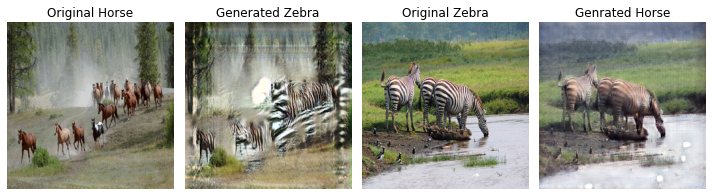

1/1 [==============================] - 0s 19ms/step


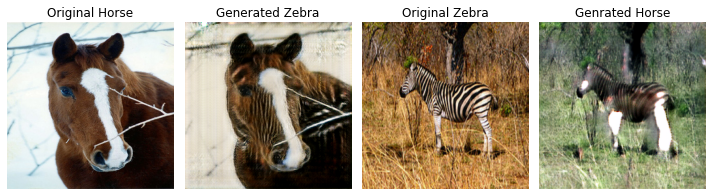

1/1 [==============================] - 0s 19ms/step


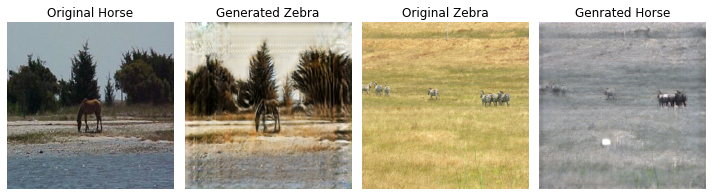

1/1 [==============================] - 0s 20ms/step


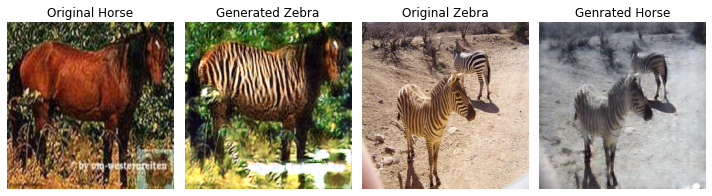

1/1 [==============================] - 0s 19ms/step


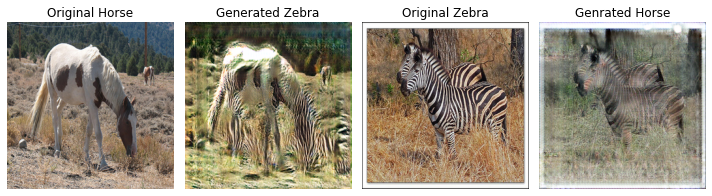

In [ ]:
show_preds(HtoZ_gen, ZtoH_gen, n_images=5)

In [ ]:
HtoZ_gen_25 = load_model("/content/drive/MyDrive/GAN Excercise/archive (3)/GeneratorHtoZ_25.h5")
ZtoH_gen_25 = load_model("/content/drive/MyDrive/GAN Excercise/archive (3)/GeneratorZtoH_25.h5")

1/1 [==============================] - 1s 898ms/step


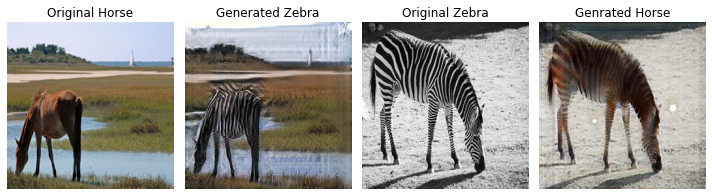

1/1 [==============================] - 0s 20ms/step


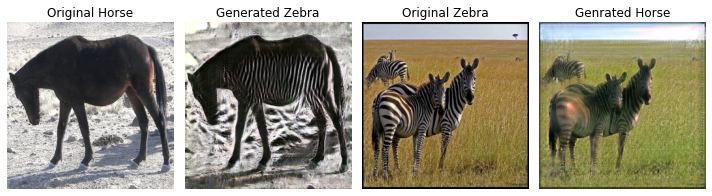

1/1 [==============================] - 0s 20ms/step


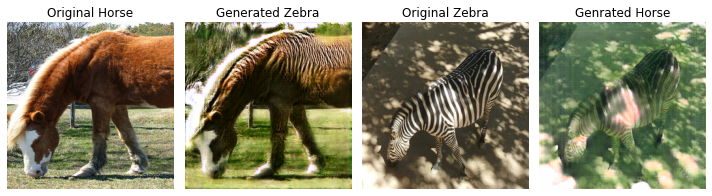

1/1 [==============================] - 0s 23ms/step


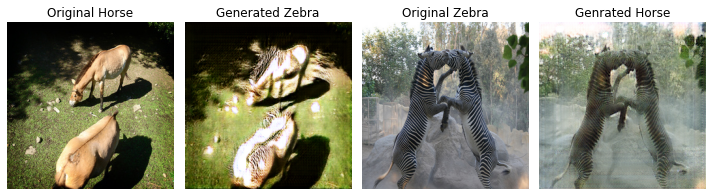

1/1 [==============================] - 0s 21ms/step


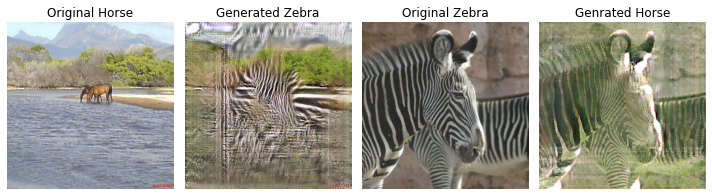

In [ ]:
show_preds(HtoZ_gen_25, ZtoH_gen_25, n_images=5)

1/1 [==============================] - 0s 21ms/step


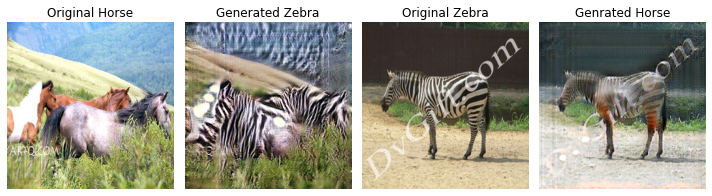

1/1 [==============================] - 0s 21ms/step


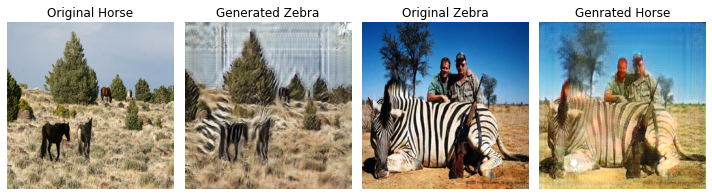

1/1 [==============================] - 0s 20ms/step


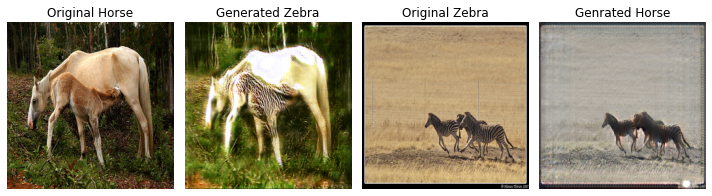

1/1 [==============================] - 0s 20ms/step


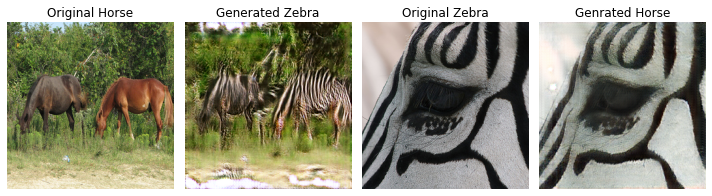

1/1 [==============================] - 0s 20ms/step


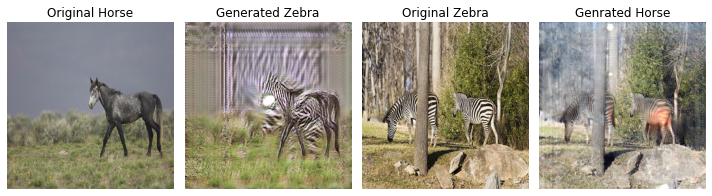

In [ ]:
show_preds(HtoZ_gen_25, ZtoH_gen_25, n_images=5)

1/1 [==============================] - 0s 20ms/step


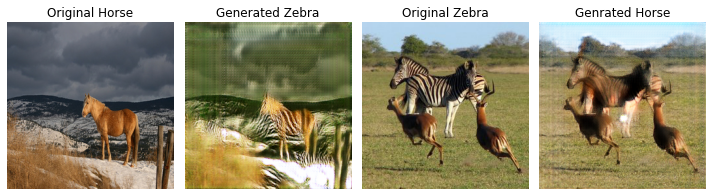

1/1 [==============================] - 0s 21ms/step


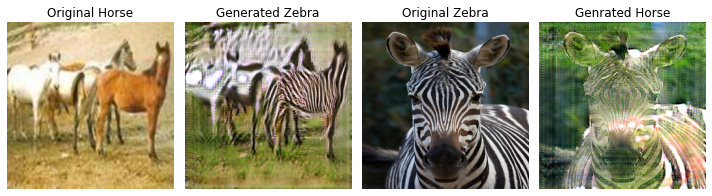

1/1 [==============================] - 0s 22ms/step


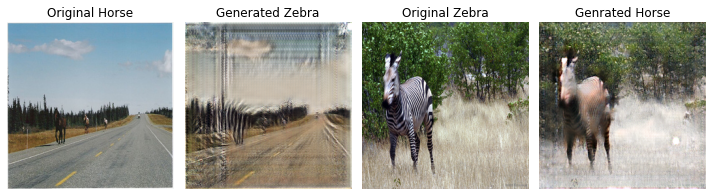

1/1 [==============================] - 0s 20ms/step


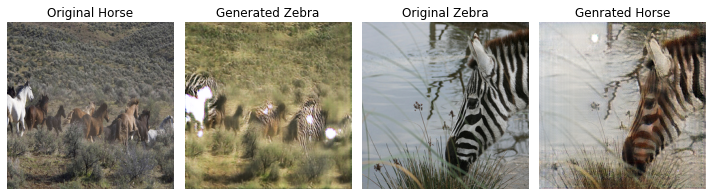

1/1 [==============================] - 0s 22ms/step


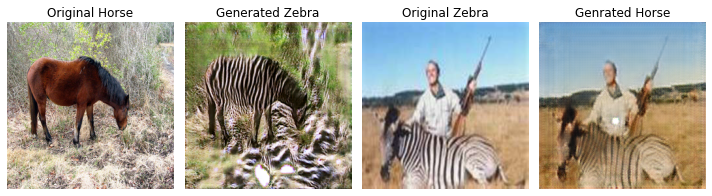

In [ ]:
show_preds(HtoZ_gen_25, ZtoH_gen_25, n_images=5)